# Real-Time Optimization Tutorial
## Williams-Otto reactor system

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import logging
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

from bunch import Bunch

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform, generate_samples_lhs
from rto.experiment.analysis import ExperimentAnalyzer

MEMORY_DATABASE = "file::memory:?cache=shared"

## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

In [4]:
# Define the input domain
grid_size = 50
g0 = 0.12
g1 = 0.08

ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 4.40345585 80.7305363 ], f*=-75.75447953926175
Model: u*=[ 4.78853778 83.20503524], f*=-26.17783591841112


## Real-Time Optimization

RTO systems are capable of iteratively driving the system towards the optimum in spite of plant-model mismatch. The entire system is displayed in the image below:

In [5]:
# creates a memory database to be used in this tutorial
!python ../scripts/create_database.py -m

Creating database to file::memory:?cache=shared


In [11]:
# Define the system parameters
u_0 = u_model
iterations = 30
noise = 0.01
initial_data_size = 5

# sample some initial data
u, y, measurements = generate_samples_uniform(model, plant, g, u_0, initial_data_size, noise=noise)
initial_data = Bunch(u=u, y=y, measurements=measurements)

adaptation_bay = MAGaussianProcesses(model, initial_data, ub=ubx, lb=lbx, filter_data=True, neighbors_type='k_last')
optimizer_bay = ModelBasedBayesianOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'hybrid', 'params': {'max_iter_init': 1}}, backoff=0.0)

rto_bay = RTOBayesian(model, plant, optimizer_bay, adaptation_bay, iterations, db_file=MEMORY_DATABASE, name='MA-GP-Bayesian', noise=noise)

Finally, we can run the RTO system. The last sampled initial operating point is used to start the system.

In [12]:
u_0_feas = u[-1]
for i in range(2):
    rto_id_bay = rto_bay.run(u_0_feas)
    print(f'Iter #{i}')

Iter #0
Iter #1


After the system stops after reaching the maximum amount of iterations, we can start analyzin the results. In order to do that, we need could use an instance of the `ExperimentAnalyzer` class.

In [13]:
import pandas as pd
# load the results
analyzer = ExperimentAnalyzer(MEMORY_DATABASE)
results = analyzer.load('MA-GP-Bayesian')

results_processed = analyzer.pre_process(results, f_plant, u_plant)

Below the results for the cost and input optimality gap are displayed. Notice that, although starting from some random initial points, the RTO system was able to drive the process towards plant optimality (0% gap), even though we use an approximate model and measurements are noisy.

/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/victor/anaconda3/envs/rto-experiments/lib/python3.10/site-packages/rto/experiment/analysis.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so canno

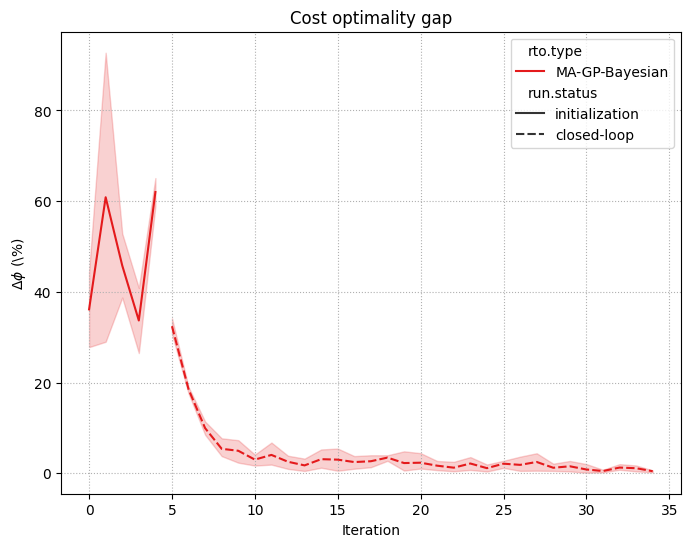

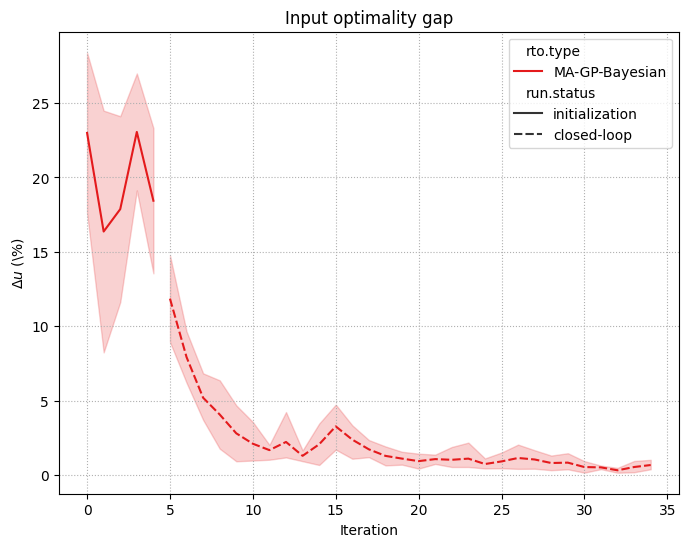

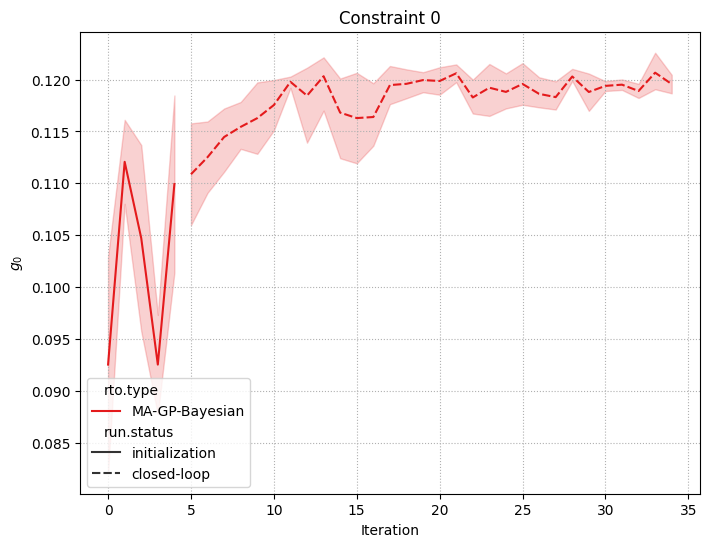

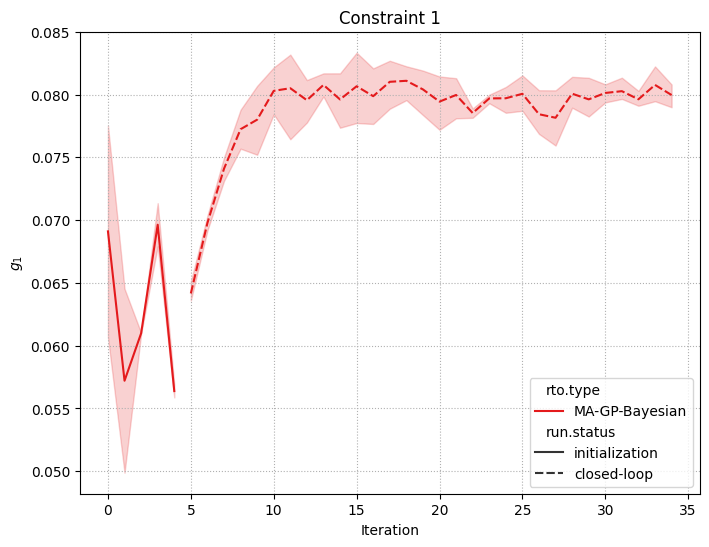

In [14]:
_ = analyzer.plot_by_iteration(results_processed, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_processed, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

## References
1. Zhang, Yale, and J. Fraser Forbes. "Extended design cost: a performance criterion for real-time optimization systems." Computers & Chemical Engineering 24, no. 8 (2000): 1829-1841.
2. de Avila Ferreira, Tafarel, Harsh A. Shukla, Timm Faulwasser, Colin N. Jones, and Dominique Bonvin. "Real-time optimization of uncertain process systems via modifier adaptation and Gaussian processes." In 2018 European Control Conference (ECC), pp. 465-470. IEEE, 2018.